In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import *
import keras
from tensorflow.keras.callbacks import Callback

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score,RocCurveDisplay

SEED = 8
IMG_SIZE = 256, 256
BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE

## Membaca data

In [ ]:
# creating main dataframe contains image paths and their classes.

def create_images_list(path):
    full_path = []
    images = sorted(os.listdir(path))
    for i in images:
        full_path.append(os.path.join(path, i))
    return full_path


classes = {0: 'Benign', 1: 'Malignant'}

train_bening_imgs = create_images_list('/kaggle/input/melanoma-cancer-dataset/train/Benign')
train_malignant_imgs = create_images_list('/kaggle/input/melanoma-cancer-dataset/train/Malignant')

full_data = pd.concat([pd.DataFrame({'image' : train_bening_imgs, 'label': 0 }),
                      pd.DataFrame({'image' : train_malignant_imgs, 'label': 1 })])
# shuffling dataset
full_data = full_data.sample(frac = 1, ignore_index = True, random_state = SEED)

# train and valid splitting
train_data, valid_data = train_test_split(full_data, test_size = 0.2, stratify = full_data['label'])

train_data = train_data.reset_index(drop = True)
valid_data = valid_data.reset_index(drop = True)

# test dataframe
test_bening_imgs = create_images_list('/kaggle/input/melanoma-cancer-dataset/test/Benign')
test_malignant_imgs = create_images_list('/kaggle/input/melanoma-cancer-dataset/test/Malignant')

test_data = pd.concat([pd.DataFrame({'image' : test_bening_imgs, 'label': 0 }),
                       pd.DataFrame({'image' : test_malignant_imgs, 'label': 1 })])
test_data = test_data.sample(frac = 1, ignore_index = True, random_state = SEED)


print('total train images \t{0}'.format(train_data.shape[0]))
print('total valid images \t{0}'.format(valid_data.shape[0]))
print('total test images \t{0}'.format(test_data.shape[0]))

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/melanoma-cancer-dataset/train/Benign'

In [ ]:
# Reading -> Resizing -> Normalization
def img_preprocessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_png(img, channels = 3)
    img = tf.image.resize(img, size =(IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0


    return img, label


# Data augmentation
img_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation((-0.3, 0.3), interpolation="bilinear"),
    RandomContrast(0.03),
    RandomCrop(*IMG_SIZE)])

In [ ]:
# Creating dataset loaders and tf.datasets

train_loader = tf.data.Dataset.from_tensor_slices((train_data['image'], train_data['label']))
train_dataset = (train_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .shuffle(BATCH_SIZE*10)
                 .batch(BATCH_SIZE)
                 .map(lambda img, label: (img_augmentation(img), label), num_parallel_calls =AUTO)
                 .prefetch(AUTO))


valid_loader = tf.data.Dataset.from_tensor_slices((valid_data['image'], valid_data['label']))
valid_dataset = (valid_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO))

test_loader = tf.data.Dataset.from_tensor_slices((test_data['image'], test_data['label']))
test_dataset = (test_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO))

In [ ]:
from tensorflow.keras.layers import Layer, Conv2D as BaseConv2D, Input, Flatten, Dense, Activation, MaxPooling2D
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

class Conv2D(Layer):
    def __init__(self, filters, kernel_size, strides=1, padding='same', activation='relu', **kwargs):
        super(Conv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.activation = activation

    def build(self, input_shape):
        self.conv = BaseConv2D(filters=self.filters, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding)

    def call(self, inputs):
        x = self.conv(inputs)
        x = Activation(self.activation)(x)
        return x

    def get_config(self):
        base_config = super().get_config()
        return {**base_config,
                "filters": self.filters,
                "kernel_size": self.kernel_size,
                "strides": self.strides,
                "padding": self.padding,
                "activation": self.activation}

In [ ]:
# a custom callback for evaluation of test set during training each 10 loop
class Test_Pred_During_Training(Callback):

    def __init__(self, model):
        self.model = model

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 10 == 0:
            test_pred = self.model.predict(test_dataset, verbose=0)
            test_pred = np.argmax(test_pred, axis=1)

            mse = mean_squared_error(test_data['label'], test_pred)
            f1 = f1_score(test_data['label'], test_pred, average='weighted')
            acc = accuracy_score(test_data['label'], test_pred)

            print('\nMean Squared Error: {0:.5f}'.format(mse))
            print('Weighted F1 Score: {0:.3f}'.format(f1))
            print('Accuracy Score: {0:.3f} %'.format(acc * 100))

            print("--" * 40)


In [ ]:
from tensorflow.keras.layers import Input, Flatten, Dense, Activation, MaxPooling2D
from tensorflow.keras.models import Model
import tensorflow as tf

# Define input shape
IMG_SIZE = (256, 256)

# Define model architecture
inp = Input(shape=(*IMG_SIZE, 3))
X = Conv2D(filters=32, kernel_size=3, activation='relu')(inp)
X = MaxPooling2D(2)(X)
X = Conv2D(filters=64, kernel_size=3, activation='relu')(X)
X = MaxPooling2D(2)(X)
X = Conv2D(filters=128, kernel_size=3, activation='relu')(X)
X = MaxPooling2D(2)(X)
X = Flatten()(X)
X = Dense(128, activation='relu')(X)
out = Dense(10, activation='softmax')(X)

# Compile model
model = Model(inputs=inp, outputs=out)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 128)       7385

In [ ]:
hist = model.fit(train_dataset, epochs=10, validation_data=valid_dataset)


Epoch 1/10
297/297 [==============================] - 684s 2s/step - loss: 0.3829 - accuracy: 0.8295 - val_loss: 0.3763 - val_accuracy: 0.8354
Epoch 2/10
297/297 [==============================] - 737s 2s/step - loss: 0.3657 - accuracy: 0.8378 - val_loss: 0.3546 - val_accuracy: 0.8304
Epoch 3/10
297/297 [==============================] - 744s 2s/step - loss: 0.3491 - accuracy: 0.8459 - val_loss: 0.3710 - val_accuracy: 0.8131
Epoch 4/10
297/297 [==============================] - 659s 2s/step - loss: 0.3480 - accuracy: 0.8447 - val_loss: 0.3555 - val_accuracy: 0.8371
Epoch 5/10
297/297 [==============================] - 923s 3s/step - loss: 0.3409 - accuracy: 0.8488 - val_loss: 0.3632 - val_accuracy: 0.8363
Epoch 6/10
297/297 [==============================] - 981s 3s/step - loss: 0.3340 - accuracy: 0.8530 - val_loss: 0.3501 - val_accuracy: 0.8354
Epoch 7/10
297/297 [==============================] - 941s 3s/step - loss: 0.3272 - accuracy: 0.8545 - val_loss: 0.3303 - val_accuracy: 0.8426

## Training Result

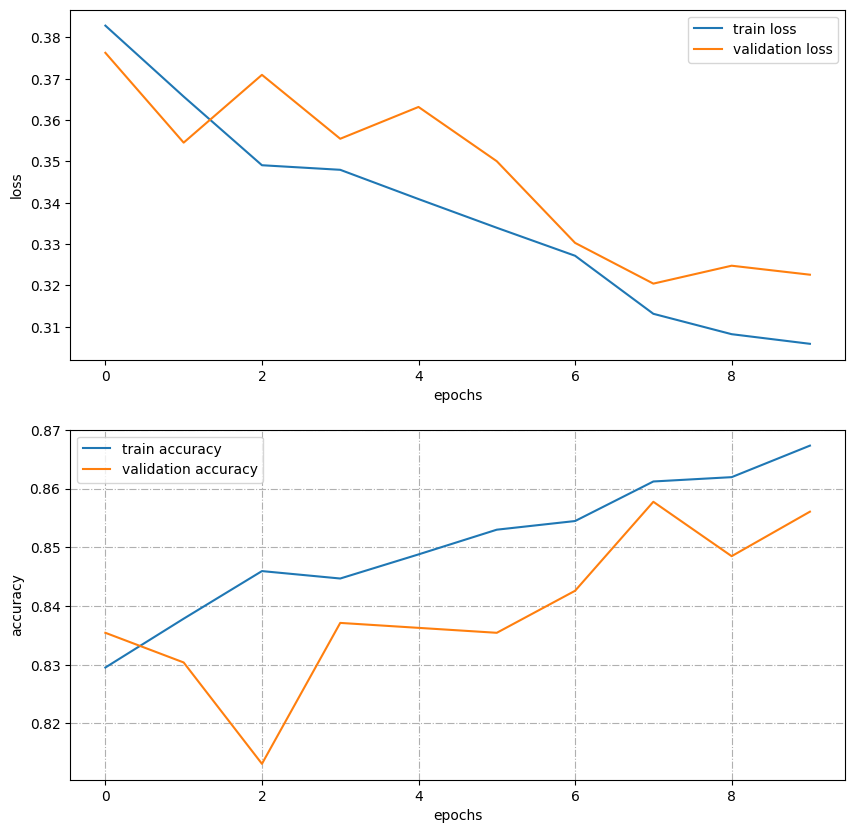

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot loss
axs[0].plot(hist.history['loss'], label='train loss')
axs[0].plot(hist.history['val_loss'], label='validation loss')
axs[0].set_xlabel('epochs', fontsize=10)
axs[0].set_ylabel('loss', fontsize=10)
axs[0].legend(['train loss', 'validation loss'], fontsize=10)

# Plot accuracy
axs[1].grid(linestyle='dashdot')
axs[1].plot(hist.history['accuracy'], label='train accuracy')
axs[1].plot(hist.history['val_accuracy'], label='validation accuracy')
axs[1].set_xlabel('epochs', fontsize=10)
axs[1].set_ylabel('accuracy', fontsize=10)
axs[1].legend(['train accuracy', 'validation accuracy'], fontsize=10)

plt.show()


## Test Prediction

In [ ]:
# Predictions and scores
test_pred = model.predict(test_dataset)
test_pred = np.argmax(test_pred, axis = 1)

mse = mean_squared_error(test_data['label'], test_pred)
f1 = f1_score(test_data['label'], test_pred, average = 'weighted')
acc = accuracy_score(test_data['label'], test_pred)

print('Mean Squared Error : {0:.5f}'.format(mse))
print('Weighted F1 Score : {0:.3f}'.format(f1))
print('Accuracy Score : {0:.3f} %'.format(acc*100))

63/63 [==============================] - 42s 659ms/step
Mean Squared Error : 0.12000
Weighted F1 Score : 0.880
Accuracy Score : 88.000 %


## Classification Report

In [ ]:
clf = classification_report(test_data['label'], test_pred, target_names = list(classes.values()))
print(clf)

              precision    recall  f1-score   support

      Benign       0.90      0.85      0.88      1000
   Malignant       0.86      0.91      0.88      1000

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000



## Confusion Matrix

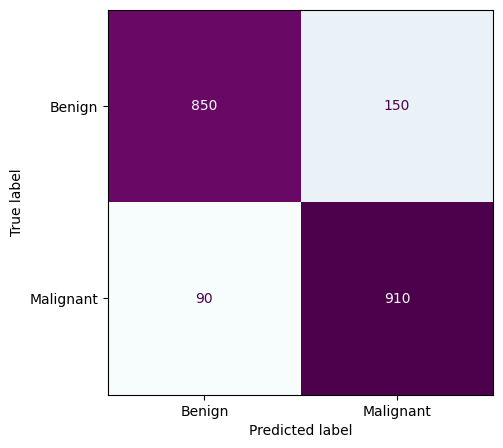

In [ ]:
cm = confusion_matrix(test_data['label'], test_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels = list(classes.values()))

fig, ax = plt.subplots(figsize=(5,5))
cmd.plot(ax=ax,  cmap = 'BuPu', colorbar = False)

## Test Set Predictions

In [ ]:
test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)

# A function that creates 5 random images in the test set and predictions

# Red title -> a false prediction
# Green title -> a true prediction

def random_test_sample_with_prediction(SEED):
    idxs = np.random.default_rng(seed=SEED).permutation(len(test_pred))[:5]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs - batch_idx * BATCH_SIZE
    idx = idxs

    fig, axs = plt.subplots(1, 5, figsize=(12, 12), dpi=150)

    for i in range(5):
        img = test_take1_[batch_idx[i]][0][image_idx[i]]
        label = test_take1_[batch_idx[i]][1][image_idx[i]].numpy()

        accuracy = 1 if int(test_pred[idx[i]]) == label else 0

        if accuracy == 1:
            axs[i].imshow(img, cmap='gray')
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i]) + ')' + '\n TRUE: ' + classes[label]
                             + '\n PRED: ' + classes[test_pred[idx[i]]]
                             + '\n Accuracy: ' + str(accuracy)
                             , fontsize=8, color='green')
        else:
            axs[i].imshow(img, cmap='gray')
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i]) + ')' + '\n TRUE: ' + classes[label]
                             + '\n PRED: ' + classes[test_pred[idx[i]]]
                             + '\n Accuracy: ' + str(accuracy)
                             , fontsize=8, color='red')


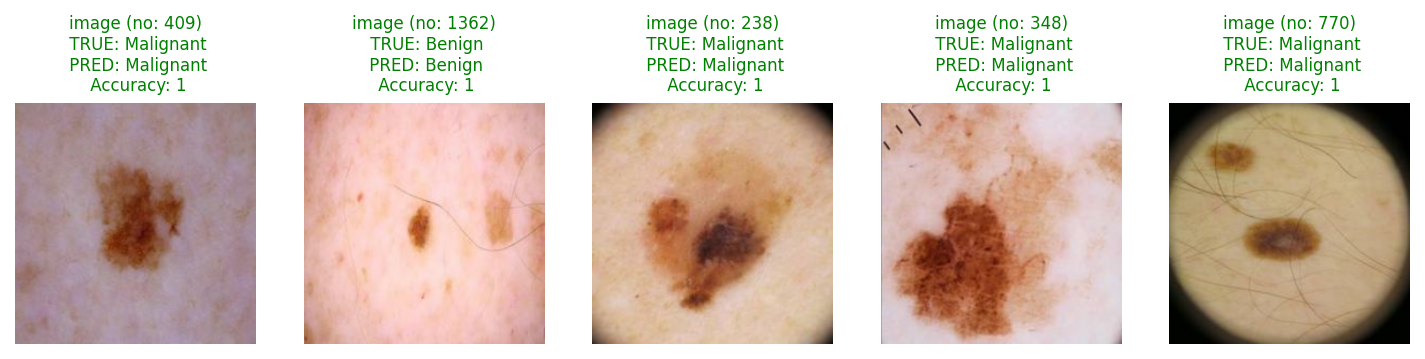

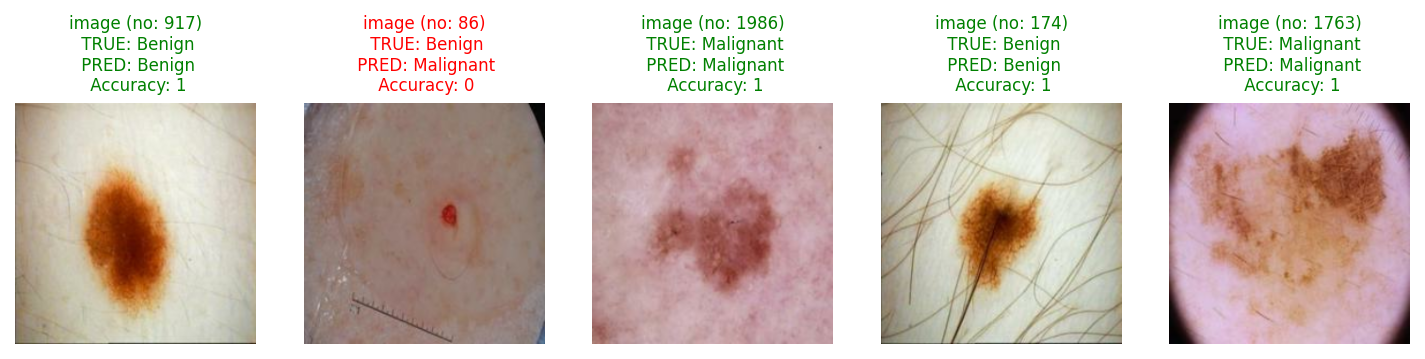

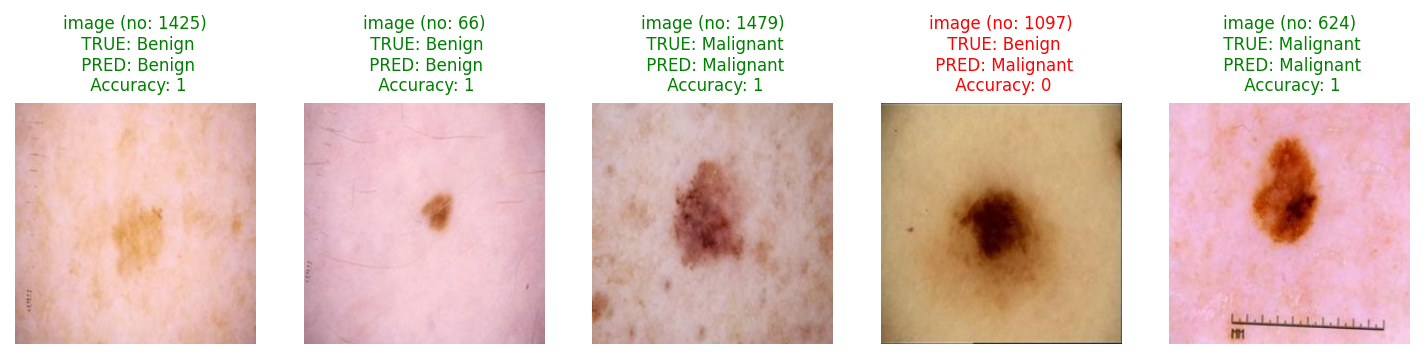

In [ ]:
# Red title -> a false prediction
# Green title -> a true prediction

random_test_sample_with_prediction(100)
random_test_sample_with_prediction(150)
random_test_sample_with_prediction(200)